# DELHI FOR EVERYBODY

### IBM APPLIED DATA SCIENCE CAPSTONE PROJECT (WEEK 2)

## TABLE OF CONTENTS

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology: Data Wrangling](#wrangling)
* [Methodology: Exploratory Data Analysis](#analysis)
* [Methodology: Model development and deployment](#model_dev)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## INTRODUCTION: BUSINESS PROBLEM <a name="introduction"></a>

This projects focuses on assisting people in **moving to Delhi, India**.

Being the capital of India, Delhi is the heart of international trades and multinational cooperates of India. The city is not only known for its diverse culture, but also for its immense sense of nationality due to the presence of major political institutions and historic monuments like the Red Fort.

The number of people projected to be living in Delhi by 2026 is around 30 million. Rapid urbanization, in conjunction with the intensified challenges of environmental degradation, has placed pressure on infrastructure, housing availability and the spread of slums. 

Known to be a city which has a place for everybody, moving to Delhi can be a life changing decision for anybody. It can, however, also be very overwhelming.

Throughout the project, every district of the capital is analysed to provide a person with a clear view of Delhi’s infrastructure and facilities to make better decisions regarding location in the city.

Even though the capital has a place for everybody, everyone should be able to make informed decisions to find a place in the heart of India based on their needs.

## DATA <a name="data"></a>

In order to analyse every aspect of Delhi, a list of all the postal offices is needed. This list is found at https://dmsouthwest.delhi.gov.in/std-pin-codes/ . It contains over 410 postal areas along with their PIN codes.

In order to access the FourSquare API, the latitudinal and longitudinal data of all the areas are collected using geocoder.

Venues belonging to various categories are also collected by using FourSquare and making API calls. 


#### IMPORTING LIBRARIES

In [1]:
#To handle dataframes and for exploratory analysis
import pandas as pd

#To get latitude and longitude values
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

#To clean data
import numpy as np

#To handle API requests
import requests

#To plot maps
import folium
import math

#For data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex

#For model deployment
from sklearn.cluster import KMeans

print('Importing successful')

Importing successful


## METHODOLOGY: DATA WRANGLING <a name="wrangling"></a>

### WEB SCRAPPING

A list of all the postal areas in Delhi are found at a webpage which is then scrapped directly into a pandas dataframe.

In [2]:
#Creating an object for the url of webpage containing information
url = 'https://dmsouthwest.delhi.gov.in/std-pin-codes/'

#Scrapping the table
full_df = pd.read_html(url)
full_df

[                 Area Name  Pin Code
 0    Ajmeri Gate Extension    110002
 1                  A G C R    110002
 2              Ansari Road    110002
 3                  Aliganj    110003
 4             Anand Parbat    110005
 ..                     ...       ...
 200             Minto Road    110002
 201            Model Basti    110005
 202              Mori Gate    110006
 203      Malka Ganj Market    110007
 204             Malka Ganj    110007
 
 [205 rows x 2 columns],
                      Area Name  Pin Code
 0            Mansarover Garden    110015
 1                   Moti Nagar    110015
 2                Malviya Nagar    110017
 3                Mahabir Nagar    110018
 4    Major Bhupinder Singh Nag    110018
 ..                         ...       ...
 200                Yusaf Sarai    110016
 201               Yamuna Vihar    110053
 202                    Zakhira    110015
 203               Zakhir Nagar    110025
 204                   Zafrabad    110053
 
 [205 rows 

### Merging tables into 1 clean data frame

There were 2 different HTML tables scrapped. They are now combined into 1 clean data frame.

In [3]:
df1 = full_df[0]
df2 = full_df[1]
df = df1.append(df2, ignore_index = True)
df

,Area Name,Pin Code
0,Ajmeri Gate Extension,110002
1,A G C R,110002
2,Ansari Road,110002
3,Aliganj,110003
4,Anand Parbat,110005
...,...,...
405,Yusaf Sarai,110016
406,Yamuna Vihar,110053
407,Zakhira,110015
408,Zakhir Nagar,110025


#### Note:

We now save the file for future reference.

In [4]:
df.to_csv('delhi_postal.csv')

### GETTING COORDINATES

In order to accquire the latitudinal and longitudinal information, the geocoder library is used.

In [5]:
#define a function to get coordinates

def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Delhi, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [7]:
#NOTE: This might take upto 10 mins

# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["Area Name"].tolist() ]

### Storing the coordinates obtained

coords contains the latitudes and longitudes of all postal areas. It now has to be stored and appended in the data frame.

In [8]:
#Displaying the first 5 elements in coords
coords[:5]

[[28.643660000000068, 77.22883000000007],
 [28.630798037285533, 77.27580261992854],
 [28.646000000000072, 77.24387000000007],
 [28.583540000000028, 77.21856000000008],
 [28.66596000000004, 77.17322000000007]]

In [9]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df.head()

,Area Name,Pin Code,Latitude,Longitude
0,Ajmeri Gate Extension,110002,28.643660,77.228830
1,A G C R,110002,28.630798,77.275803
2,Ansari Road,110002,28.646000,77.243870
3,Aliganj,110003,28.583540,77.218560
4,Anand Parbat,110005,28.665960,77.173220


### Checking for empty values

In case the geocoder didn't find the latitudes or longitudes of an area, we drop them by first replacing the white spaces or '?' or 'na' values by NumPy NaN and then delete the rows using pd.dropna()

In [11]:
df = df.replace(r' ',np.nan)
df = df.replace('?', np.nan)
df.dropna(axis = 0) #axis = 0 to delete rows containing null values
df.shape

(410, 4)

### Checking data types

In [12]:
df.dtypes

Area Name     object
Pin Code       int64
Latitude     float64
Longitude    float64
dtype: object

In [13]:
#Saving the data frame obtained in a csv file
df.to_csv('delhi_latlong.csv')

### USING FOURSQUARE API

### Defining version and credentials

In [95]:
CLIENT_ID = 'ID' # your Foursquare ID
CLIENT_SECRET = 'SECRET' # your Foursquare Secret
VERSION = '20180605'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ID
CLIENT_SECRET:SECRET


### Getting 250 venues within 2000 m of a postal office

In [15]:
#Setting the radius
radius = 2000

#Setting the number of venues
LIMIT = 250

#List to store venues
venues = []

In [16]:
for lat, long, area in zip(df['Latitude'], df['Longitude'], df['Area Name']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            area,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [18]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Area', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df

(15823, 7)


,Area,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Ajmeri Gate Extension,28.64366,77.22883,Naturals Ice Cream,28.634455,77.222139,Ice Cream Shop
1,Ajmeri Gate Extension,28.64366,77.22883,Haveli Dharampura,28.653247,77.232309,Hotel
2,Ajmeri Gate Extension,28.64366,77.22883,Panchayat Paan Parlour,28.634073,77.222645,Indian Restaurant
3,Ajmeri Gate Extension,28.64366,77.22883,Sagar Ratna,28.635487,77.220650,Indian Restaurant
4,Ajmeri Gate Extension,28.64366,77.22883,Immigrants Project - A Cafe in History,28.634055,77.218867,Café
...,...,...,...,...,...,...,...
15818,Zafrabad,28.67970,77.27151,Shivaji park,28.682657,77.285503,Park
15819,Zafrabad,28.67970,77.27151,yamuna vihar,28.689816,77.283876,Park
15820,Zafrabad,28.67970,77.27151,Shahdara Metro Station,28.673344,77.289011,Light Rail Station
15821,Zafrabad,28.67970,77.27151,Halidrams,28.675918,77.290126,Vegetarian / Vegan Restaurant


In [19]:
#Saving all venues
venues_df.to_csv('delhi_venues.csv')

### Quality venues

Not all of the venue categories are of importance when moving to a new city. Hence, the data is cleaned with only quality venues and infrastructures.

In [20]:
#Finding out the total number of current venue categories.
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 228 uniques categories.


In [21]:
print(venues_df['VenueCategory'].unique())

['Ice Cream Shop' 'Hotel' 'Indian Restaurant' 'Café' 'Lounge' 'Plaza'
 'Clothing Store' 'Tibetan Restaurant' 'Bakery' 'South Indian Restaurant'
 'Restaurant' 'Molecular Gastronomy Restaurant' 'Arcade'
 'Fast Food Restaurant' 'BBQ Joint' 'Paper / Office Supplies Store'
 'Dessert Shop' 'Hardware Store' 'Chinese Restaurant' 'Italian Restaurant'
 'Coffee Shop' 'Pizza Place' 'Mosque' 'Bar' 'Food & Drink Shop'
 'Asian Restaurant' 'Gastropub' 'Road' 'North Indian Restaurant'
 'Art Gallery' 'Market' 'Snack Place' 'Theater'
 'Indian Chinese Restaurant' 'Food' 'Monument / Landmark' 'Flea Market'
 'Breakfast Spot' 'Motel' 'History Museum' 'Museum' 'Hostel'
 'Cricket Ground' 'Pub' 'Hindu Temple' 'Shopping Mall'
 'Light Rail Station' 'Multiplex' 'Food Court' 'River' 'Moving Target'
 'Stadium' 'Movie Theater' 'Frozen Yogurt Shop' 'Campground'
 'Udupi Restaurant' 'Performing Arts Venue' 'Deli / Bodega'
 'English Restaurant' 'Park' 'Japanese Restaurant' 'Athletics & Sports'
 'Sandwich Place' 'Mediterr

In [23]:
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Clothing Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Paper / Office Supplies Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Convenience Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Department Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Electronics Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Big Box Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Grocery Store'),'Stores',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Fruit & Vegetable Store'),'Stores',venues_df.VenueCategory)

venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Flea Market'),'Market',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Farmers Market'),'Market',venues_df.VenueCategory)

venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Light Rail Station'),'Commute',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Bus Station'),'Commute',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Train Station'),'Commute',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Metro Station'),'Commute',venues_df.VenueCategory)

venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Park'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Athletics & Sports'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Basketball Court'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Soccer Field'),'Sports',venues_df.VenueCategory)

venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Playground'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Hockey Arena'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Soccer Stadium'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Pool'),'Sports',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Tennis Court'),'Sports',venues_df.VenueCategory)

venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Gym / Fitness Center'),'Fitness',venues_df.VenueCategory)
venues_df['VenueCategory'] = np.where((venues_df.VenueCategory == 'Gym'),'Fitness',venues_df.VenueCategory)

In [30]:
venues_df

,Area,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Ajmeri Gate Extension,28.64366,77.22883,Naturals Ice Cream,28.634455,77.222139,Ice Cream Shop
1,Ajmeri Gate Extension,28.64366,77.22883,Haveli Dharampura,28.653247,77.232309,Hotel
2,Ajmeri Gate Extension,28.64366,77.22883,Panchayat Paan Parlour,28.634073,77.222645,Indian Restaurant
3,Ajmeri Gate Extension,28.64366,77.22883,Sagar Ratna,28.635487,77.220650,Indian Restaurant
4,Ajmeri Gate Extension,28.64366,77.22883,Immigrants Project - A Cafe in History,28.634055,77.218867,Café
...,...,...,...,...,...,...,...
15818,Zafrabad,28.67970,77.27151,Shivaji park,28.682657,77.285503,Sports
15819,Zafrabad,28.67970,77.27151,yamuna vihar,28.689816,77.283876,Sports
15820,Zafrabad,28.67970,77.27151,Shahdara Metro Station,28.673344,77.289011,Commute
15821,Zafrabad,28.67970,77.27151,Halidrams,28.675918,77.290126,Vegetarian / Vegan Restaurant


In [28]:
# Defining specific venue categories to keep in the data frame
quality_columns = ['Hotel', 'Restaurant', 'Stores', 'Market', 'Shopping Mall', 'Commute', 'Sports', 'University', 'ATM', 'Bank', 'Airport', 'Pharmacy', 'High School']

In [41]:
quality_df = venues_df.loc[venues_df['VenueCategory'].isin(quality_columns)]
quality_df

,Area,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
1,Ajmeri Gate Extension,28.64366,77.22883,Haveli Dharampura,28.653247,77.232309,Hotel
8,Ajmeri Gate Extension,28.64366,77.22883,bloomrooms @ New Delhi Railway Station,28.645537,77.217701,Hotel
10,Ajmeri Gate Extension,28.64366,77.22883,Fabindia,28.632012,77.217729,Stores
12,Ajmeri Gate Extension,28.64366,77.22883,The Prime Balaji Deluxe @ New Delhi Railway St...,28.645247,77.217433,Hotel
20,Ajmeri Gate Extension,28.64366,77.22883,The Indian Grill Restaurant,28.646141,77.215133,Restaurant
...,...,...,...,...,...,...,...
15816,Zafrabad,28.67970,77.27151,Welcome Metro Station,28.671902,77.277772,Commute
15817,Zafrabad,28.67970,77.27151,Seelampur Metro Station,28.669805,77.266846,Commute
15818,Zafrabad,28.67970,77.27151,Shivaji park,28.682657,77.285503,Sports
15819,Zafrabad,28.67970,77.27151,yamuna vihar,28.689816,77.283876,Sports


In [42]:
print(quality_df['VenueCategory'].unique())

['Hotel' 'Stores' 'Restaurant' 'Market' 'Shopping Mall' 'Commute' 'Sports'
 'University' 'Pharmacy' 'ATM' 'Bank' 'Airport' 'High School']


In [43]:
quality_df.to_csv('delhi_quality.csv')

### Note:

The final data frame for the analysis is now stored in the form of a csv file at delhi_quality.csv.

## METHODOLOGY: EXPLORATORY DATA ANALYSIS <a name="analysis"></a>

### MAP OF DELHI WITH POSTAL AREAS MARKED

In order to understand the locational data, it is a good practice to first see where all the different postal areas are present in Delhi.

In [44]:
#Specifying the latitude and longitude of Delhi
address = 'Delhi, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


In [48]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Area Name'], df['Pin Code']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

In [49]:
# save the map as HTML file
map_delhi.save('delhi_map.html')

#### NOTE:
If GitHub doesn't display the map, please check the repository folder.

It will contain a file name 'delhi_map.html'. The map can be accessed through that file.

### Number of venues in each area

Total number of quality infrastructure present in all the different areas of Delhi are calculated.

In [50]:
count_venues = quality_df.groupby(['Area']).count()
count_venues

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Area,,,,,,
A F Rajokari,2,2,2,2,2,2
A G C R,4,4,4,4,4,4
A P S Colony,8,8,8,8,8,8
A T Mills,2,2,2,2,2,2
Adarsh Nagar,3,3,3,3,3,3
...,...,...,...,...,...,...
Yamuna Vihar,7,7,7,7,7,7
Yusaf Sarai,12,12,12,12,12,12
Zafrabad,5,5,5,5,5,5


### Finding out top 10 venues of every location

In [51]:
# one hot encoding
onehot = pd.get_dummies(quality_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Area'] = quality_df['Area'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
delhi_grouped = onehot.groupby('Area').mean().reset_index()
onehot.head()

,Area,ATM,Airport,Bank,Commute,High School,Hotel,Market,Pharmacy,Restaurant,Shopping Mall,Sports,Stores,University
1,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
8,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
10,Ajmeri Gate Extension,0,0,0,0,0,0,0,0,0,0,0,1,0
12,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
20,Ajmeri Gate Extension,0,0,0,0,0,0,0,0,1,0,0,0,0


In [52]:
num_top_venues = 5
for hood in delhi_grouped['Area']:
    print("---- "+hood+" ----")
    temp =delhi_grouped[delhi_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- A F Rajokari ----
           venue  freq
0  Shopping Mall   0.5
1         Stores   0.5
2            ATM   0.0
3        Airport   0.0
4           Bank   0.0


---- A G C R ----
           venue  freq
0        Commute   0.5
1  Shopping Mall   0.5
2            ATM   0.0
3        Airport   0.0
4           Bank   0.0


---- A P S Colony ----
           venue  freq
0          Hotel  0.25
1         Sports  0.25
2         Market  0.12
3       Pharmacy  0.12
4  Shopping Mall  0.12


---- A T Mills ----
        venue  freq
0       Hotel   0.5
1  Restaurant   0.5
2         ATM   0.0
3     Airport   0.0
4        Bank   0.0


---- Adarsh Nagar ----
     venue  freq
0  Commute  0.67
1   Sports  0.33
2      ATM  0.00
3  Airport  0.00
4     Bank  0.00


---- Ajmeri Gate Extension ----
        venue  freq
0       Hotel  0.67
1      Market  0.17
2      Stores  0.11
3  Restaurant  0.06
4         ATM  0.00


---- Aliganj ----
        venue  freq
0      Market   0.3
1     Commute   0.2
2  Restaurant  

     venue  freq
0  Commute   0.5
1   Sports   0.5
2      ATM   0.0
3  Airport   0.0
4     Bank   0.0


---- Gymkhana Club ----
     venue  freq
0   Stores  0.50
1    Hotel  0.25
2   Sports  0.25
3      ATM  0.00
4  Airport  0.00


---- Haiderpur ----
        venue  freq
0     Commute  0.33
1      Stores  0.33
2       Hotel  0.17
3  Restaurant  0.17
4         ATM  0.00


---- Hamdard Dawakhana ----
        venue  freq
0       Hotel  0.67
1      Market  0.15
2  Restaurant  0.11
3     Commute  0.04
4      Stores  0.04


---- Hari Nagar Ashram ----
        venue  freq
0       Hotel  0.56
1      Market  0.11
2  Restaurant  0.11
3      Sports  0.11
4      Stores  0.11


---- Hari Nagar Be Block ----
     venue  freq
0    Hotel  0.67
1  Commute  0.17
2   Market  0.17
3      ATM  0.00
4  Airport  0.00


---- Hari Nagar Da & Db Block ----
     venue  freq
0  Commute  0.67
1   Market  0.33
2      ATM  0.00
3  Airport  0.00
4     Bank  0.00


---- Harijan Sewak Sangh ----
           venue  freq


        venue  freq
0         ATM   0.5
1  Restaurant   0.5
2     Airport   0.0
3        Bank   0.0
4     Commute   0.0


---- Khichripur ----
     venue  freq
0   Market   0.5
1   Sports   0.5
2      ATM   0.0
3  Airport   0.0
4     Bank   0.0


---- Khyalla Phase I ----
     venue  freq
0  Airport   0.5
1   Stores   0.5
2      ATM   0.0
3     Bank   0.0
4  Commute   0.0


---- Khyalla Phase II ----
     venue  freq
0   Stores  0.67
1      ATM  0.33
2  Airport  0.00
3     Bank  0.00
4  Commute  0.00


---- Kidwai Nagar ----
           venue  freq
0         Market  0.33
1         Sports  0.20
2        Commute  0.13
3     Restaurant  0.13
4  Shopping Mall  0.13


---- Kidwai Nagar West ----
     venue  freq
0   Market  0.30
1    Hotel  0.20
2   Sports  0.20
3  Commute  0.10
4  Airport  0.05


---- Kirby Place ----
           venue  freq
0         Stores  0.50
1         Market  0.25
2  Shopping Mall  0.25
3            ATM  0.00
4        Airport  0.00


---- Kirti Nagar ----
           ve

4  Commute   0.0


---- Munirka ----
           venue  freq
0     Restaurant  0.25
1  Shopping Mall  0.25
2         Stores  0.25
3         Market  0.12
4         Sports  0.12


---- N Block Greater ----
        venue  freq
0      Market  0.40
1  Restaurant  0.27
2      Stores  0.13
3     Commute  0.07
4       Hotel  0.07


---- N I E Compus ----
           venue  freq
0        Commute  0.44
1  Shopping Mall  0.22
2          Hotel  0.11
3         Sports  0.11
4         Stores  0.11


---- N P Laboratories ----
         venue  freq
0          ATM   1.0
1      Airport   0.0
2         Bank   0.0
3      Commute   0.0
4  High School   0.0


---- Nagloi ----
     venue  freq
0  Commute  0.50
1   Sports  0.25
2   Stores  0.25
3      ATM  0.00
4  Airport  0.00


---- Najafgarh ----
     venue  freq
0      ATM   0.5
1   Stores   0.5
2  Airport   0.0
3     Bank   0.0
4  Commute   0.0


---- Najafgarh Road ----
           venue  freq
0        Commute  0.43
1          Hotel  0.14
2         Market  

        venue  freq
0      Market  0.36
1  Restaurant  0.27
2       Hotel  0.18
3     Commute  0.09
4      Stores  0.09


---- Sarai Rohila ----
     venue  freq
0  Commute  0.50
1    Hotel  0.25
2   Sports  0.25
3      ATM  0.00
4  Airport  0.00


---- Saraswati Vihar ----
         venue  freq
0      Commute   1.0
1          ATM   0.0
2      Airport   0.0
3         Bank   0.0
4  High School   0.0


---- Sarojini Nagar H O ----
           venue  freq
0          Hotel   0.4
1         Market   0.2
2  Shopping Mall   0.2
3         Sports   0.2
4            ATM   0.0


---- Sat Nahar ----
     venue  freq
0    Hotel  0.50
1  Commute  0.25
2   Market  0.12
3   Sports  0.12
4      ATM  0.00


---- Satyawati Nagar ----
        venue  freq
0  Restaurant  0.50
1      Market  0.17
2      Sports  0.17
3      Stores  0.17
4         ATM  0.00


---- Sectt North ----
        venue  freq
0  Restaurant  0.38
1     Commute  0.25
2      Stores  0.25
3       Hotel  0.12
4         ATM  0.00


---- Sectt S

           venue  freq
0          Hotel  0.33
1  Shopping Mall  0.33
2         Sports  0.17
3         Stores  0.17
4            ATM  0.00


---- Vishwan Nagar ----
           venue  freq
0          Hotel  0.33
1  Shopping Mall  0.33
2         Sports  0.17
3         Stores  0.17
4            ATM  0.00


---- Vivek Vihar ----
     venue  freq
0   Sports   0.4
1     Bank   0.2
2  Commute   0.2
3    Hotel   0.2
4      ATM   0.0


---- Wazir Nagar ----
        venue  freq
0      Market  0.28
1     Commute  0.17
2      Sports  0.17
3  Restaurant  0.11
4      Stores  0.11


---- Wazirpur Phase III ----
        venue  freq
0      Sports  0.38
1  Restaurant  0.25
2     Commute  0.12
3      Market  0.12
4      Stores  0.12


---- Work Shop ----
     venue  freq
0      ATM  0.33
1  Commute  0.33
2   Stores  0.33
3  Airport  0.00
4     Bank  0.00


---- Yamuna Vihar ----
     venue  freq
0      ATM  0.57
1   Stores  0.29
2   Sports  0.14
3  Airport  0.00
4     Bank  0.00


---- Yusaf Sarai ----
  

In [53]:
delhi_grouped

,Area,ATM,Airport,Bank,Commute,High School,Hotel,Market,Pharmacy,Restaurant,Shopping Mall,Sports,Stores,University
0,A F Rajokari,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.500,0.000000,0.500000,0.000
1,A G C R,0.000000,0.0,0.0,0.500000,0.0,0.000000,0.000000,0.000,0.000000,0.500,0.000000,0.000000,0.000
2,A P S Colony,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.125000,0.125,0.000000,0.125,0.250000,0.000000,0.125
3,A T Mills,0.000000,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.000,0.500000,0.000,0.000000,0.000000,0.000
4,Adarsh Nagar,0.000000,0.0,0.0,0.666667,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.333333,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Yamuna Vihar,0.571429,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.142857,0.285714,0.000
384,Yusaf Sarai,0.000000,0.0,0.0,0.083333,0.0,0.000000,0.333333,0.000,0.333333,0.000,0.250000,0.000000,0.000
385,Zafrabad,0.000000,0.0,0.0,0.600000,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.400000,0.000000,0.000
386,Zakhir Nagar,0.000000,0.0,0.0,0.000000,0.0,0.666667,0.000000,0.000,0.000000,0.000,0.333333,0.000000,0.000


In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Area'] = delhi_grouped['Area']

for ind in np.arange(delhi_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A F Rajokari,Stores,Shopping Mall,University,Sports,Restaurant,Pharmacy,Market,Hotel,High School,Commute
1,A G C R,Shopping Mall,Commute,University,Stores,Sports,Restaurant,Pharmacy,Market,Hotel,High School
2,A P S Colony,Sports,Hotel,University,Shopping Mall,Pharmacy,Market,Stores,Restaurant,High School,Commute
3,A T Mills,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute
4,Adarsh Nagar,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School


In [57]:
#Storing the data frame with top 10 venues according to area
venues_sorted.to_csv('delhi_top_ten.csv')

### Analysing the total infrastructure of Delhi

In [65]:
count_cat = quality_df.groupby(['VenueCategory']).count()
count_cat['VenueCategory'] = quality_columns
count_cat['Area']

VenueCategory
ATM                66
Airport            10
Bank               18
Commute           468
High School         1
Hotel            1018
Market            428
Pharmacy            9
Restaurant        465
Shopping Mall     165
Sports            360
Stores            342
University          9
Name: Area, dtype: int64

In [66]:
#Converting the above table into a dictionary
data = {'Venue Type':['ATM', 'Airport', 'Bank', 'Commute', 'High School', 'Hotel', 'Market', 'Pharmacy', 'Restaurant', 
               'Shopping Mall', 'Sports','Stores','University'],
         'Count': [66, 10, 18, 468, 1, 1018, 428, 9, 465, 165, 360, 342, 9]}

#Converting dict into dataframe
plot_data = pd.DataFrame.from_dict(data)
plot_data

,Venue Type,Count
0,ATM,66
1,Airport,10
2,Bank,18
3,Commute,468
4,High School,1
5,Hotel,1018
6,Market,428
7,Pharmacy,9
8,Restaurant,465
9,Shopping Mall,165


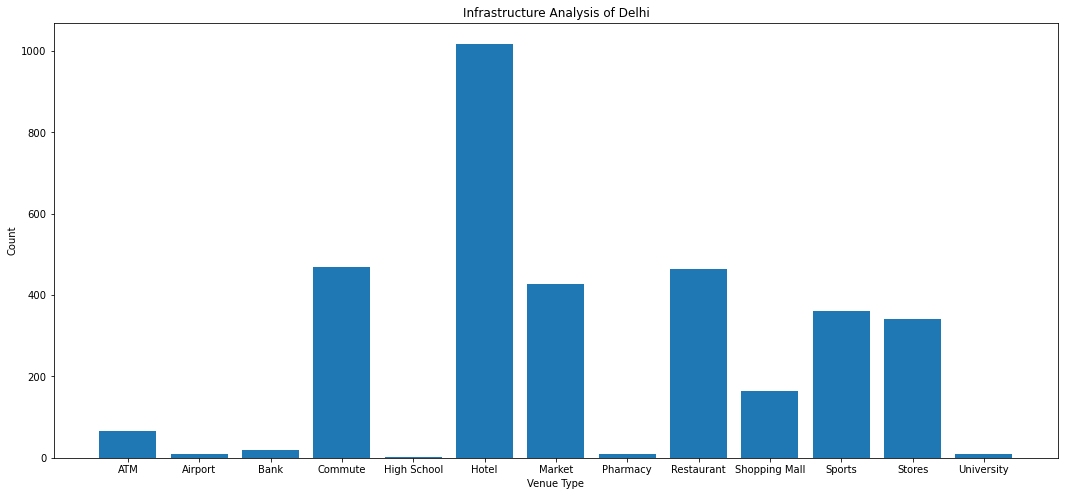

In [67]:
# Changing default values for parameters individually
plt.rcParams["figure.figsize"] = (18, 8)
 
# Plot a line graph
plt.bar(plot_data['Venue Type'], plot_data['Count'])
# Add labels and title
plt.title("Infrastructure Analysis of Delhi")
plt.xlabel("Venue Type")
plt.ylabel("Count")
 
plt.show()

#### Note:

If GitHub doesn't display the bar graph, please check the repository folder.

It will contain a file 'Infra analysis of Delhi.png'. The graph can be accessed from there.

## METHODOLOGY: MODEL DEVELOPMENT AND DEPLOYMENT <a name="model_dev"></a>

### CLUSTERING

To find out suitable neighbourhoods to live in, clustering is done on the venue data of the various areas in Delhi.

KMeans clustering algorithm is used for the same.

### One hot encoding

Categorical values are converted into binary values so that the algorithm can be applied on the data.

In [78]:
# one hot encoding
onehot = pd.get_dummies(quality_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Area'] = quality_df['Area'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
delhi_grouped = onehot.groupby('Area').mean().reset_index()
onehot.head()

,Area,ATM,Airport,Bank,Commute,High School,Hotel,Market,Pharmacy,Restaurant,Shopping Mall,Sports,Stores,University
1,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
8,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
10,Ajmeri Gate Extension,0,0,0,0,0,0,0,0,0,0,0,1,0
12,Ajmeri Gate Extension,0,0,0,0,0,1,0,0,0,0,0,0,0
20,Ajmeri Gate Extension,0,0,0,0,0,0,0,0,1,0,0,0,0


In [79]:
num_top_venues = 5
for hood in delhi_grouped['Area']:
    print("---- "+hood+" ----")
    temp =delhi_grouped[delhi_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- A F Rajokari ----
           venue  freq
0  Shopping Mall   0.5
1         Stores   0.5
2            ATM   0.0
3        Airport   0.0
4           Bank   0.0


---- A G C R ----
           venue  freq
0        Commute   0.5
1  Shopping Mall   0.5
2            ATM   0.0
3        Airport   0.0
4           Bank   0.0


---- A P S Colony ----
           venue  freq
0          Hotel  0.25
1         Sports  0.25
2         Market  0.12
3       Pharmacy  0.12
4  Shopping Mall  0.12


---- A T Mills ----
        venue  freq
0       Hotel   0.5
1  Restaurant   0.5
2         ATM   0.0
3     Airport   0.0
4        Bank   0.0


---- Adarsh Nagar ----
     venue  freq
0  Commute  0.67
1   Sports  0.33
2      ATM  0.00
3  Airport  0.00
4     Bank  0.00


---- Ajmeri Gate Extension ----
        venue  freq
0       Hotel  0.67
1      Market  0.17
2      Stores  0.11
3  Restaurant  0.06
4         ATM  0.00


---- Aliganj ----
        venue  freq
0      Market   0.3
1     Commute   0.2
2  Restaurant  

4      Stores  0.07


---- Election Commission ----
        venue  freq
0       Hotel  0.69
1  Restaurant  0.19
2     Commute  0.06
3      Stores  0.06
4         ATM  0.00


---- Farashkhana ----
        venue  freq
0       Hotel  0.64
1      Market  0.16
2  Restaurant  0.12
3     Commute  0.04
4      Stores  0.04


---- Fateh Nagar ----
           venue  freq
0         Stores  0.55
1     Restaurant  0.27
2        Commute  0.09
3  Shopping Mall  0.09
4            ATM  0.00


---- Fatehpuri ----
        venue  freq
0       Hotel  0.64
1      Market  0.16
2  Restaurant  0.12
3     Commute  0.04
4      Stores  0.04


---- Flatted Factories Complex ----
     venue  freq
0   Sports  0.50
1     Bank  0.25
2  Commute  0.25
3      ATM  0.00
4  Airport  0.00


---- G T S Nagar ----
           venue  freq
0        Commute  0.25
1          Hotel  0.25
2         Sports  0.25
3  Shopping Mall  0.12
4         Stores  0.12


---- Gandhi Nagar ----
     venue  freq
0   Sports   1.0
1      ATM   0.0
2 

        venue  freq
0       Hotel  0.25
1      Market  0.25
2  Restaurant  0.19
3     Commute  0.12
4      Stores  0.12


---- Lajpat Rai Chowk ----
        venue  freq
0       Hotel  0.68
1      Market  0.16
2      Stores  0.11
3  Restaurant  0.05
4         ATM  0.00


---- Lancer Road Market ----
         venue  freq
0      Commute   1.0
1          ATM   0.0
2      Airport   0.0
3         Bank   0.0
4  High School   0.0


---- Lawrence Road ----
           venue  freq
0        Commute  0.50
1         Sports  0.33
2  Shopping Mall  0.17
3            ATM  0.00
4        Airport  0.00


---- Laxmi Bai Nagar ----
           venue  freq
0         Market  0.33
1        Commute  0.22
2         Sports  0.22
3          Hotel  0.11
4  Shopping Mall  0.11


---- Laxmi Nagar Market ----
           venue  freq
0        Commute   0.5
1  Shopping Mall   0.5
2            ATM   0.0
3        Airport   0.0
4           Bank   0.0


---- Laxminarain Mandir ----
         venue  freq
0      Commute   1.0
1 

4  Airport  0.00


---- Patrachar Road ----
           venue  freq
0  Shopping Mall  0.33
1         Stores  0.33
2          Hotel  0.22
3        Commute  0.11
4            ATM  0.00


---- Patrachar Vidyala ----
           venue  freq
0  Shopping Mall  0.33
1         Stores  0.33
2          Hotel  0.22
3        Commute  0.11
4            ATM  0.00


---- Pitampura ----
           venue  freq
0        Commute  0.50
1          Hotel  0.17
2  Shopping Mall  0.17
3         Sports  0.17
4            ATM  0.00


---- Possangipur ----
           venue  freq
0        Commute  0.67
1     Restaurant  0.17
2  Shopping Mall  0.17
3            ATM  0.00
4        Airport  0.00


---- Postal Saving Bureau ----
        venue  freq
0       Hotel  0.76
1  Restaurant  0.14
2     Commute  0.05
3      Stores  0.05
4         ATM  0.00


---- Power House ----
        venue  freq
0      Market  0.27
1  Restaurant  0.27
2      Sports  0.20
3       Hotel  0.13
4     Commute  0.07


---- Pragati Maidan ----
    

        venue  freq
0       Hotel  0.79
1  Restaurant  0.11
2      Market  0.05
3      Stores  0.05
4         ATM  0.00


---- T B Hospital ----
         venue  freq
0      Commute   1.0
1          ATM   0.0
2      Airport   0.0
3         Bank   0.0
4  High School   0.0


---- Tatarpur ----
         venue  freq
0      Commute   1.0
1          ATM   0.0
2      Airport   0.0
3         Bank   0.0
4  High School   0.0


---- Teliwara ----
           venue  freq
0          Hotel  0.29
1  Shopping Mall  0.29
2         Sports  0.29
3         Stores  0.14
4            ATM  0.00


---- Than Singh Nagar ----
     venue  freq
0    Hotel  0.71
1  Commute  0.29
2      ATM  0.00
3  Airport  0.00
4     Bank  0.00


---- Tihar ----
     venue  freq
0      ATM  0.67
1   Stores  0.33
2  Airport  0.00
3     Bank  0.00
4  Commute  0.00


---- Tilak Nagar ----
           venue  freq
0         Stores  0.45
1     Restaurant  0.27
2  Shopping Mall  0.18
3        Commute  0.09
4            ATM  0.00


---- Til

In [80]:
delhi_grouped

,Area,ATM,Airport,Bank,Commute,High School,Hotel,Market,Pharmacy,Restaurant,Shopping Mall,Sports,Stores,University
0,A F Rajokari,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.500,0.000000,0.500000,0.000
1,A G C R,0.000000,0.0,0.0,0.500000,0.0,0.000000,0.000000,0.000,0.000000,0.500,0.000000,0.000000,0.000
2,A P S Colony,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.125000,0.125,0.000000,0.125,0.250000,0.000000,0.125
3,A T Mills,0.000000,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.000,0.500000,0.000,0.000000,0.000000,0.000
4,Adarsh Nagar,0.000000,0.0,0.0,0.666667,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.333333,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Yamuna Vihar,0.571429,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.142857,0.285714,0.000
384,Yusaf Sarai,0.000000,0.0,0.0,0.083333,0.0,0.000000,0.333333,0.000,0.333333,0.000,0.250000,0.000000,0.000
385,Zafrabad,0.000000,0.0,0.0,0.600000,0.0,0.000000,0.000000,0.000,0.000000,0.000,0.400000,0.000000,0.000
386,Zakhir Nagar,0.000000,0.0,0.0,0.000000,0.0,0.666667,0.000000,0.000,0.000000,0.000,0.333333,0.000000,0.000


In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [82]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Area'] = delhi_grouped['Area']

for ind in np.arange(delhi_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A F Rajokari,Stores,Shopping Mall,University,Sports,Restaurant,Pharmacy,Market,Hotel,High School,Commute
1,A G C R,Shopping Mall,Commute,University,Stores,Sports,Restaurant,Pharmacy,Market,Hotel,High School
2,A P S Colony,Sports,Hotel,University,Shopping Mall,Pharmacy,Market,Stores,Restaurant,High School,Commute
3,A T Mills,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute
4,Adarsh Nagar,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School


In [83]:
# Using K-Means to cluster neighborhood into 3 clusters
delhi_grouped_clustering = delhi_grouped.drop('Area', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(delhi_grouped_clustering)
kmeans.labels_

array([2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 2,
       2, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 0, 2, 2,
       2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0,
       1, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2,
       2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 1,
       1, 2, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1,
       1, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2,
       2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       0, 2, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1,
       1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,

In [84]:
# Data frame consisting of venues and clusters
venues_sorted['Clusters'] = kmeans.labels_
venues_sorted

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,A F Rajokari,Stores,Shopping Mall,University,Sports,Restaurant,Pharmacy,Market,Hotel,High School,Commute,2
1,A G C R,Shopping Mall,Commute,University,Stores,Sports,Restaurant,Pharmacy,Market,Hotel,High School,1
2,A P S Colony,Sports,Hotel,University,Shopping Mall,Pharmacy,Market,Stores,Restaurant,High School,Commute,2
3,A T Mills,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute,0
4,Adarsh Nagar,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1
...,...,...,...,...,...,...,...,...,...,...,...,...
383,Yamuna Vihar,ATM,Stores,Sports,University,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,2
384,Yusaf Sarai,Restaurant,Market,Sports,Commute,University,Stores,Shopping Mall,Pharmacy,Hotel,High School,2
385,Zafrabad,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1
386,Zakhir Nagar,Hotel,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,High School,Commute,0


In [85]:
#Saving the file with clusters
venues_sorted.to_csv('venues_clustered.csv')

### Adding latitude and longtidues of areas from the first data frame to the one with clusters

In [86]:
df['Area'] = df['Area Name']
del df['Area Name']
df

,Pin Code,Latitude,Longitude,Area
0,110002,28.643660,77.228830,Ajmeri Gate Extension
1,110002,28.630798,77.275803,A G C R
2,110002,28.646000,77.243870,Ansari Road
3,110003,28.583540,77.218560,Aliganj
4,110005,28.665960,77.173220,Anand Parbat
...,...,...,...,...
405,110016,28.558630,77.208040,Yusaf Sarai
406,110053,28.700610,77.272020,Yamuna Vihar
407,110015,28.669784,77.162625,Zakhira
408,110025,28.567530,77.279780,Zakhir Nagar


In [87]:
final_df = pd.merge(venues_sorted,df,on='Area',how='left')
final_df

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters,Pin Code,Latitude,Longitude
0,A F Rajokari,Stores,Shopping Mall,University,Sports,Restaurant,Pharmacy,Market,Hotel,High School,Commute,2,110038,28.519370,77.121260
1,A G C R,Shopping Mall,Commute,University,Stores,Sports,Restaurant,Pharmacy,Market,Hotel,High School,1,110002,28.630798,77.275803
2,A P S Colony,Sports,Hotel,University,Shopping Mall,Pharmacy,Market,Stores,Restaurant,High School,Commute,2,110010,28.575230,77.178230
3,A T Mills,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute,0,110033,29.683990,76.991170
4,Adarsh Nagar,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110033,28.720350,77.172640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,Yamuna Vihar,ATM,Stores,Sports,University,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,2,110053,28.700610,77.272020
389,Yusaf Sarai,Restaurant,Market,Sports,Commute,University,Stores,Shopping Mall,Pharmacy,Hotel,High School,2,110016,28.558630,77.208040
390,Zafrabad,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110053,28.679700,77.271510
391,Zakhir Nagar,Hotel,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,High School,Commute,0,110025,28.567530,77.279780


## RESULTS AND DISCUSSION <a name="results"></a>

### EXAMINING CLUSTERS

3 clusters are obtained.

### Cluster 1

In [92]:
cluster1 = final_df.loc[final_df['Clusters'] == 0, final_df.columns[list(range(0, final_df.shape[1]))]]
cluster1

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters,Pin Code,Latitude,Longitude
3,A T Mills,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute,0,110033,29.683990,76.991170
5,Ajmeri Gate Extension,Hotel,Market,Stores,Restaurant,University,Sports,Shopping Mall,Pharmacy,High School,Commute,0,110002,28.643660,77.228830
10,Ambrohi,Hotel,Restaurant,Stores,Commute,University,Sports,Shopping Mall,Pharmacy,Market,High School,0,110045,28.634100,77.216890
11,Amrit Kaur Market,Hotel,Stores,Restaurant,Market,Commute,University,Sports,Shopping Mall,Pharmacy,High School,0,110055,28.643040,77.218180
18,Ansari Road,Market,Hotel,Stores,University,Sports,Shopping Mall,Restaurant,Pharmacy,High School,Commute,0,110002,28.646000,77.243870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,Tughlakabad,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute,0,110044,28.518580,77.275890
372,Tughlakabad A F Station,Restaurant,Hotel,University,Stores,Sports,Shopping Mall,Pharmacy,Market,High School,Commute,0,110044,28.518580,77.275890
374,Udyog Bhawan,Hotel,Restaurant,Sports,Commute,Market,University,Stores,Shopping Mall,Pharmacy,High School,0,110011,28.611850,77.212040
376,Vasant Vihar I,Hotel,University,Stores,Sports,Shopping Mall,Restaurant,Pharmacy,Market,High School,Commute,0,110057,27.906793,78.048754


### Cluster 2

In [93]:
cluster2 = final_df.loc[final_df['Clusters'] == 1, final_df.columns[list(range(0, final_df.shape[1]))]]
cluster2

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters,Pin Code,Latitude,Longitude
1,A G C R,Shopping Mall,Commute,University,Stores,Sports,Restaurant,Pharmacy,Market,Hotel,High School,1,110002,28.630798,77.275803
4,Adarsh Nagar,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110033,28.720350,77.172640
7,Alipur,Restaurant,Commute,University,Stores,Sports,Shopping Mall,Pharmacy,Market,Hotel,High School,1,110036,28.798050,77.144260
8,Amar Colony,Commute,Stores,Sports,University,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110024,28.678440,77.049390
12,Anand Nagar,Commute,Sports,Market,Hotel,University,Stores,Shopping Mall,Restaurant,Pharmacy,High School,1,110005,28.674490,77.167560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,Tatarpur,Commute,University,Stores,Sports,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110027,28.688448,77.317079
369,Timarpur,Commute,University,Stores,Sports,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110007,28.700780,77.221160
375,Uttam Nagar,Stores,Commute,University,Sports,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110059,28.617390,77.052810
390,Zafrabad,Commute,Sports,University,Stores,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,1,110053,28.679700,77.271510


### Cluster 3

In [94]:
cluster3 = final_df.loc[final_df['Clusters'] == 2, final_df.columns[list(range(0, final_df.shape[1]))]]
cluster3

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters,Pin Code,Latitude,Longitude
0,A F Rajokari,Stores,Shopping Mall,University,Sports,Restaurant,Pharmacy,Market,Hotel,High School,Commute,2,110038,28.51937,77.12126
2,A P S Colony,Sports,Hotel,University,Shopping Mall,Pharmacy,Market,Stores,Restaurant,High School,Commute,2,110010,28.57523,77.17823
6,Aliganj,Market,Sports,Restaurant,Commute,Hotel,University,Stores,Shopping Mall,Pharmacy,High School,2,110003,28.58354,77.21856
9,Ambedkar Nagar,Stores,Hotel,Shopping Mall,Restaurant,Market,University,Sports,Pharmacy,High School,Commute,2,110062,28.51949,77.23500
13,Anand Niketan,Sports,University,Stores,Restaurant,Market,Shopping Mall,Pharmacy,Hotel,High School,Commute,2,110021,28.57555,77.16103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Wazir Nagar,Market,Sports,Commute,Stores,Restaurant,Shopping Mall,Hotel,Airport,University,Pharmacy,2,110007,28.57029,77.22510
386,Wazirpur Phase III,Sports,Restaurant,Stores,Market,Commute,University,Shopping Mall,Pharmacy,Hotel,High School,2,110052,28.69302,77.18162
387,Work Shop,Stores,Commute,ATM,University,Sports,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,2,110010,23.11945,83.19366
388,Yamuna Vihar,ATM,Stores,Sports,University,Shopping Mall,Restaurant,Pharmacy,Market,Hotel,High School,2,110053,28.70061,77.27202


### VISUALIZING CLUSTERS

The 3 clusters are now visualized on the map of Delhi with different colours for each cluster.

In [88]:
#Locational data of Delhi
address = 'Delhi, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


In [90]:
kclusters = 10
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(final_df['Latitude'], 
                                   final_df['Longitude'], 
                                   final_df['Area'], 
                                   final_df['Clusters']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [91]:
# save the map as HTML file
map_clusters.save('clusters_map.html')

#### Note:

If GitHub doesn't display the map, please check the repository folder.

It will contain a file named 'clusters_map.html'. The map can be accessed from there.

## CONCLUSION <a name="conclusion"></a>

Purpose of this project was to identify the postal areas with the best infrastructure in Delhi in order to help citizens make informed decisions about moving in Delhi.

By clustering the different areas based on the types of venues and their frequencies from the FourSquare data, first the top types of places in an area is analysed. Then, after futher extensive collection of locations which satisfy some basic requirements of a person moving to Delhi, infrastructure of Delhi is analysed.

Clustering of all the neighbourhoods in Delhi was performed in order to create major zones of interests.

Final decission on optimal location differ from person to person and will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, real estate availability, prices, social and economic dynamics of every neighborhood etc.